### File 7:
Target:
* Add LR Scheduler - OneCycleLR (total_steps - 15, max_lr - 0.1)
* Change batch size to 32 to improve the test accuracy.
 
Results:
* Parameters: 9.9k
* Training Accuracy: 99.44
* Testing Accuracy: 99.60

Best Testing Accuracy: 99.61 (12th epoch)

Consistent for 12,13,14 epochs - 99.61, 99.60, 99.60

Analysis:
* Underfitting reduced even more (0.16 diff).
* OneCycleLR worked best. Final accuracy is 99.6.
* Aim for < 8k parameters.








## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

## Data Transformations

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=16)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## The Model 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output = 26*26*10

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(30),
            nn.ReLU()
        ) # output = 24*24*30
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) #24*24*10

        self.pool1 = nn.MaxPool2d(2, 2) # output = 12*12*10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output = 10*10*14

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output = 8*8*14
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14,out_channels=14,kernel_size=(3, 3),padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output = 6*6*14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14,out_channels=14,kernel_size=(3, 3),padding=1, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU() 
        ) # output = 6*6*14
        
        self.gap = nn.Sequential(nn.AdaptiveAvgPool2d(1)) # output = 1*1*14
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels = 14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) 
        ) # output = 1*1*10
         
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1) 

## Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 30, 24, 24]           2,700
       BatchNorm2d-5           [-1, 30, 24, 24]              60
              ReLU-6           [-1, 30, 24, 24]               0
            Conv2d-7           [-1, 10, 24, 24]             300
       BatchNorm2d-8           [-1, 10, 24, 24]              20
              ReLU-9           [-1, 10, 24, 24]               0
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
      BatchNorm2d-12           [-1, 14, 10, 10]              28
             ReLU-13           [-1, 14, 10, 10]               0
           Conv2d-14             [-1, 1

## Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing the Model

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.1, total_steps=15, anneal_strategy='cos')


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.016820669174194336 Batch_id=1874 Accuracy=91.22: 100%|██████████| 1875/1875 [00:25<00:00, 72.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9866/10000 (98.66%)

EPOCH: 1


Loss=0.06018334627151489 Batch_id=1874 Accuracy=97.02: 100%|██████████| 1875/1875 [00:25<00:00, 74.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9890/10000 (98.90%)

EPOCH: 2


Loss=0.012235090136528015 Batch_id=1874 Accuracy=97.75: 100%|██████████| 1875/1875 [00:25<00:00, 74.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.012220889329910278 Batch_id=1874 Accuracy=98.16: 100%|██████████| 1875/1875 [00:25<00:00, 73.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.091041699051857 Batch_id=1874 Accuracy=98.40: 100%|██████████| 1875/1875 [00:25<00:00, 73.77it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.014463871717453003 Batch_id=1874 Accuracy=98.58: 100%|██████████| 1875/1875 [00:25<00:00, 74.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.19333593547344208 Batch_id=1874 Accuracy=98.78: 100%|██████████| 1875/1875 [00:25<00:00, 73.64it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.003755331039428711 Batch_id=1874 Accuracy=98.82: 100%|██████████| 1875/1875 [00:25<00:00, 73.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.3095184564590454 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:25<00:00, 73.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.005725830793380737 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:25<00:00, 73.60it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)

EPOCH: 10


Loss=0.06670533865690231 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:25<00:00, 73.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Loss=0.0028149187564849854 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:25<00:00, 72.93it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.00398920476436615 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:25<00:00, 73.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 9961/10000 (99.61%)

EPOCH: 13


Loss=0.07974071800708771 Batch_id=1874 Accuracy=99.42: 100%|██████████| 1875/1875 [00:25<00:00, 73.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9960/10000 (99.60%)

EPOCH: 14


Loss=0.0011136233806610107 Batch_id=1874 Accuracy=99.44: 100%|██████████| 1875/1875 [00:25<00:00, 73.52it/s]



Test set: Average loss: 0.0144, Accuracy: 9960/10000 (99.60%)



## Loss and Accuracy

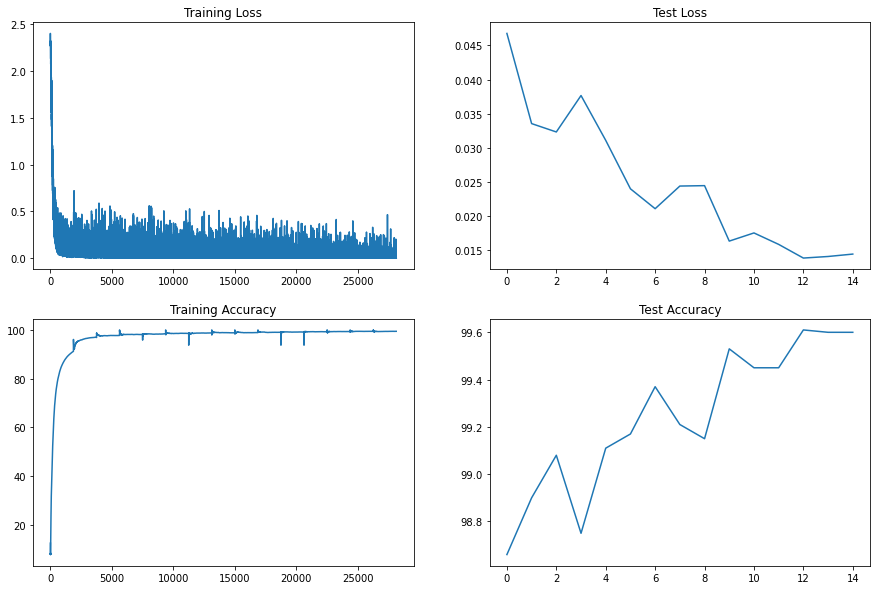

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy");

### That's all Folks!